In [2]:
!pip show tensorflow

Name: tensorflow
Version: 2.16.2
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/harsh/mynlpenv/lib/python3.11/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: tensorflow-macos


In [1]:
# Imports
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

In [3]:
data = pd.read_csv('INDIGO_history.csv')
print(data.head())
print(data.info())
print(data.describe())

         date       close         high         low        open    volume
0  2015-11-10  831.624573   852.717359  804.843844  811.290167  27351793
1  2015-11-13  951.877136   978.326091  869.307196  870.255186   8446622
2  2015-11-16  937.515137   985.910036  915.995743  958.418314   3358159
3  2015-11-17  982.971252   995.295127  925.428225  938.510480   3694092
4  2015-11-18  991.266113  1013.212113  962.494572  964.343165   3621593
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2367 entries, 0 to 2366
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2367 non-null   object 
 1   close   2367 non-null   float64
 2   high    2367 non-null   float64
 3   low     2367 non-null   float64
 4   open    2367 non-null   float64
 5   volume  2367 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 111.1+ KB
None
             close         high          low         open        volume
count  2367.000000 

Text(0, 0.5, 'Price (USD)')

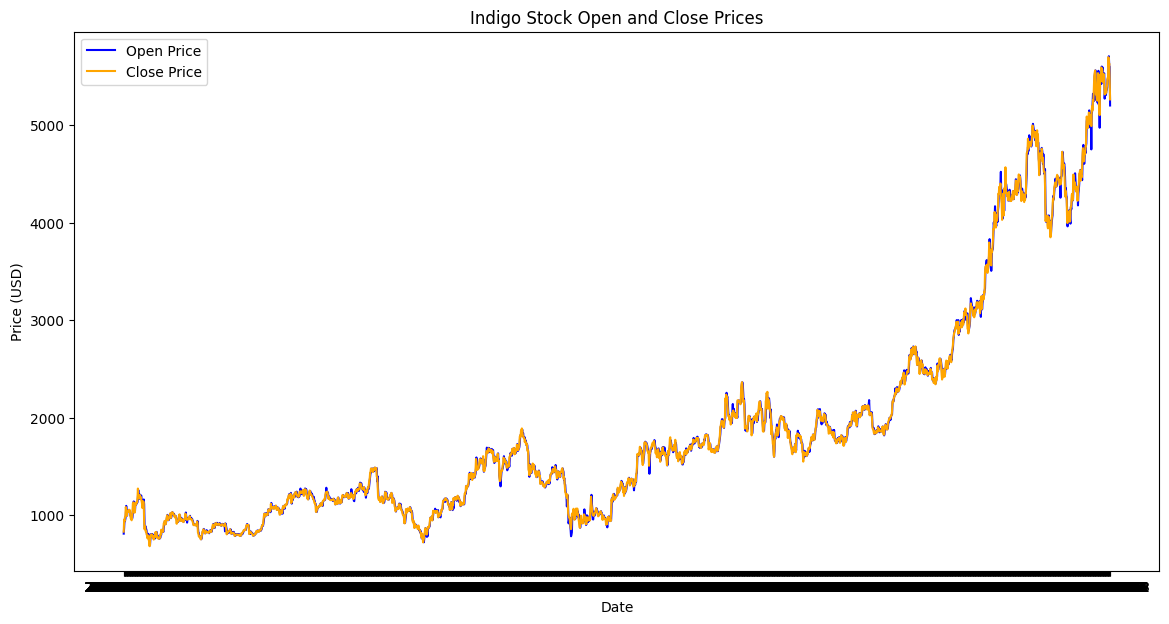

In [4]:
# Initial data visualization 
# Plot 1 : Open and Close prices
plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['open'], label='Open Price', color='blue')
plt.plot(data['date'], data['close'], label='Close Price', color='orange')
plt.title('Indigo Stock Open and Close Prices')
plt.xlabel('Date')
plt.legend()
plt.ylabel('Price (USD)')

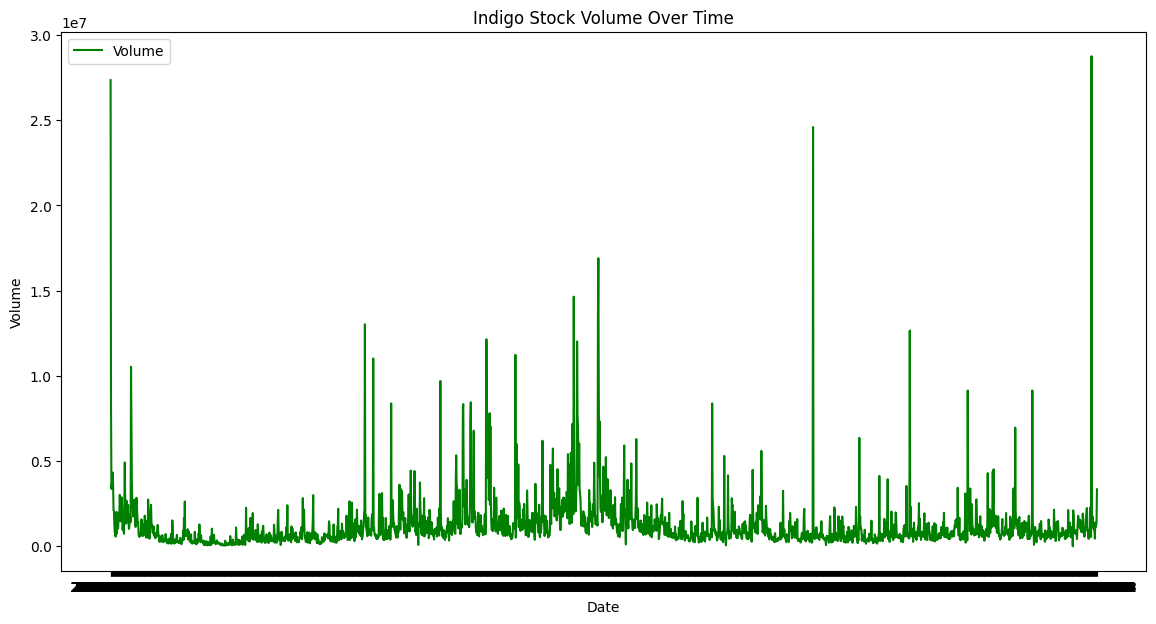

In [5]:
# Plot 2 : Volume over time
plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['volume'], label='Volume', color='green')
plt.title('Indigo Stock Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()


In [6]:
# Drop unnecessary columns (non-numeric or redundant)
numeric_data = data.select_dtypes(include=["int64", "float64"])

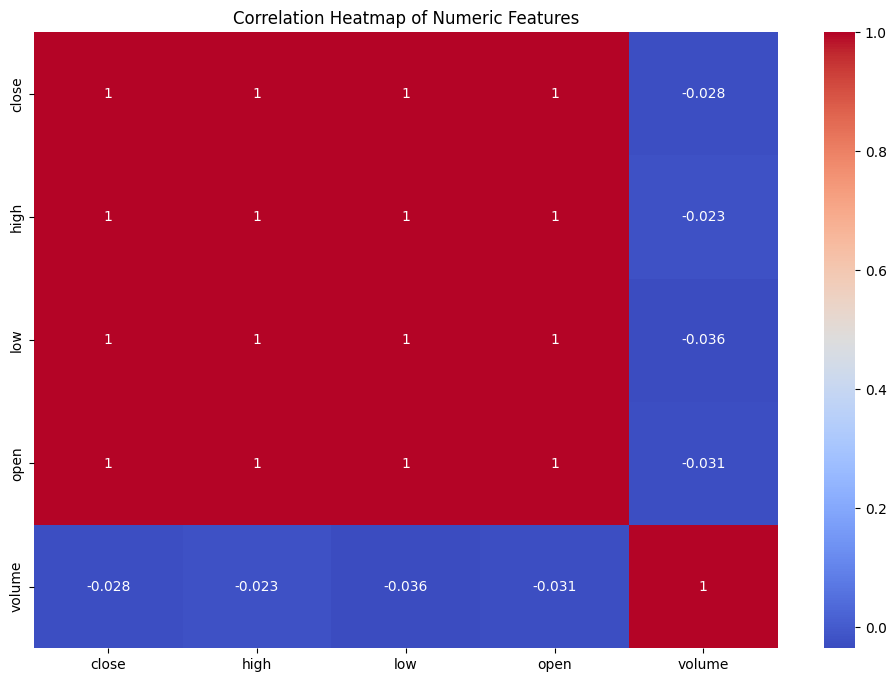

In [7]:
# Check for correlation between numeric features
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


In [8]:
# Convert date to datetime
data['date'] = pd.to_datetime(data['date'])

In [ ]:
prediction = data.loc[
    (data['date'] > datetime(2013,1,1)) & (data['date'] < datetime(2018,1,1))
]

In [9]:
# Prepare the LSTM Model (Sequential)
dataset = data['close'].values 
train_size = int(np.ceil(len(dataset) * 0.95))

In [10]:
print(dataset.reshape(-1, 1).shape)

(2367, 1)


In [11]:
# Data Preprocessing
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset.reshape(-1, 1))
training_data = scaled_data[:train_size]

In [12]:
X_train, y_train = [], []

# Create a sliding window of 60 days for the stock
for i in range(60, len(training_data)):
    X_train.append(training_data[i-60:i, 0])
    y_train.append(training_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [13]:
print(X_train.shape)

(2189, 60)


In [14]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # Making it 3D for Tensorflow
print(X_train.shape)

(2189, 60, 1)


# Building the Model

In [15]:
model = keras.models.Sequential()

In [16]:
# First layer - learns the patterns from past 60 days of stock prices 
model.add(keras.layers.LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))

2025-06-14 20:28:33.379986: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-06-14 20:28:33.380229: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-06-14 20:28:33.380235: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-06-14 20:28:33.380700: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-14 20:28:33.381030: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/harsh/mynlpenv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models

In [17]:
# Second layer - This layer keeps the important features from the first layer
model.add(keras.layers.LSTM(units=64, return_sequences=False))

In [18]:
# Third Layer (Dense Layer) - This layer helps the model adjust and learn complex patterns in the data
model.add(keras.layers.Dense(units=128, activation='relu'))

In [19]:
# Fourth Layer (Dropout Layer) , to prevent overfitting - it prevents the model from being too sensitive to the training data and helps it perform better on new data
model.add(keras.layers.Dropout(0.5))

In [20]:
# Final output layer - This layer predicts the stock prices 
model.add(keras.layers.Dense(units=1)) 

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(optimizer='adam', loss='mae', metrics=[keras.metrics.RootMeanSquaredError()])

# Train the model

In [23]:
training = model.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30


2025-06-14 20:28:49.933842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.2863 - root_mean_squared_error: 0.4212
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1006 - root_mean_squared_error: 0.1524
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0935 - root_mean_squared_error: 0.1307
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0888 - root_mean_squared_error: 0.1274
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0831 - root_mean_squared_error: 0.1281
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0861 - root_mean_squared_error: 0.1288
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0757 - root_mean_squared_error: 0.1080
Epoch 8/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0702 - root_mean_squared_error: 0.1010
Epoch 9/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0782 - root_mean_squared_error: 0.1150
Epoch 10/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0734 - root_mean_squared_error: 0.1055
Epoch 11/3

In [ ]:
# Prep test data
test_data = scaled_data[train_size - 60:]
X_test, y_test = [], dataset[train_size:]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [35]:
unscaled_X_test = scaler.inverse_transform(X_test.reshape(-1, 1)).reshape(X_test.shape[0], X_test.shape[1])
print(unscaled_X_test.shape)
print(unscaled_X_test[117][59])

(118, 60)
5476.5


In [25]:
# Make predictions 
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


In [41]:
print(predictions.shape)

(118, 1)


/var/folders/lk/9zql6l_s4fn6rj08c1xp00k00000gn/T/ipykernel_25613/3110640257.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


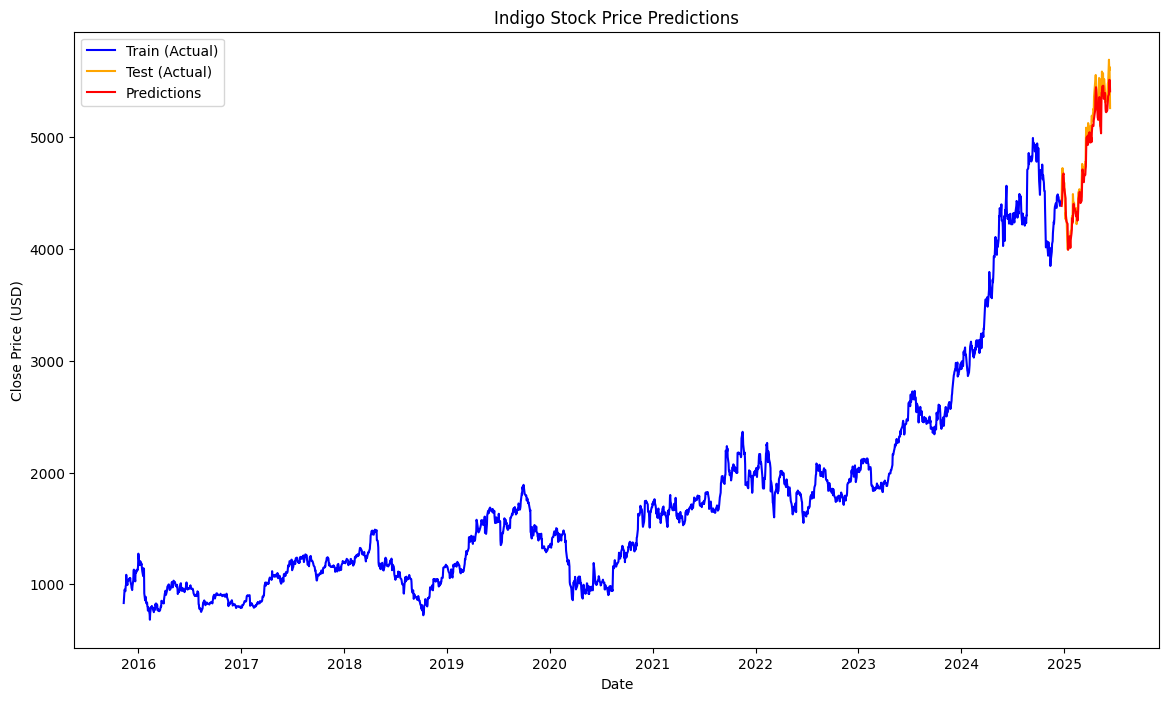

In [52]:
# Plotting data
train = data[:train_size]
test = data[train_size:]
test['Predictions'] = predictions
plt.figure(figsize=(14, 8))
plt.plot(train['date'], train['close'], label='Train (Actual)', color='blue')
plt.plot(test['date'], test['close'], label='Test (Actual)', color='orange')
plt.plot(test['date'], test['Predictions'], label='Predictions', color='red')
plt.title('Indigo Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

In [36]:
# Now lets forecast the next 30 days
# We will retrain the model with the entire dataset
X_train_full, y_train_full = [], []
for i in range(60, len(scaled_data)):
    X_train_full.append(scaled_data[i-60:i, 0])
    y_train_full.append(scaled_data[i, 0])
X_train_full, y_train_full = np.array(X_train_full), np.array(y_train_full)
X_train_full = np.reshape(X_train_full, (X_train_full.shape[0], X_train_full.shape[1], 1))

In [39]:
print(X_train_full.shape)

(2307, 60, 1)


In [40]:
model.fit(X_train_full, y_train_full, epochs=30, batch_size=32)

Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0726 - root_mean_squared_error: 0.1194
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0739 - root_mean_squared_error: 0.1223
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0706 - root_mean_squared_error: 0.1108
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0720 - root_mean_squared_error: 0.1192
Epoch 5/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0712 - root_mean_squared_error: 0.1130
Epoch 6/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0700 - root_mean_squared_error: 0.1113
Epoch 7/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0686 - root_mean_squared_error: 0.1060
Epoch 8/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0634 - root_mean_squared_error: 0.1007
Epoch 9/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0758 - root_mean_squared_error: 0.1284
Epoch 10/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0688 - root_mean_squared_error: 0.1150

In [50]:
unscaled_X_test_future = scaler.inverse_transform(scaled_data[-60:]).reshape(1, -1)
print(unscaled_X_test_future)

[[4780.45019531 4780.45019531 4980.54980469 5086.75       5044.04980469
  4970.35009766 5006.70019531 5025.14990234 5127.79980469 5115.35009766
  5028.         5068.25       5003.60009766 5098.89990234 4988.70019531
  5157.04980469 5193.75       5151.10009766 5256.         5244.5
  5366.         5496.5        5534.         5558.5        5520.5
  5313.5        5341.         5264.         5249.5        5321.5
  5531.5        5322.         5296.5        5146.         5101.
  5476.5        5521.         5451.5        5589.         5562.5
  5574.5        5442.         5461.5        5503.         5521.
  5420.         5313.5        5330.5        5322.         5330.
  5333.         5383.5        5416.         5482.         5480.5
  5695.         5599.         5631.         5476.5        5262.        ]]


In [59]:
# Now lets make predictions for the next 30 days
X_test_future = scaled_data[train_size-60:train_size]
X_test_future = np.reshape(X_test_future, (1, X_test_future.shape[0], 1))
future_predictions = []
previous_data = scaled_data[-60:]
prev_date = data['date'].iloc[train_size]
for _ in range(10):
    pred = model.predict(X_test_future)
    pred2 = scaler.inverse_transform(pred)
    # Let's also print the date for each prediction
    date = prev_date + pd.Timedelta(days=_+1)
    print(f"Predicted price for next day {date} : {pred2[0, 0]}")
    future_predictions.append(pred[0, 0])
    previous_data = np.append(previous_data, pred[0, 0])
    X_test_future = np.reshape(previous_data[-60:], (1, 60, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted price for next day 2024-12-24 00:00:00 : 4361.8154296875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted price for next day 2024-12-25 00:00:00 : 4354.69580078125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted price for next day 2024-12-26 00:00:00 : 4400.779296875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted price for next day 2024-12-27 00:00:00 : 4425.78515625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted price for next day 2024-12-28 00:00:00 : 4434.60888671875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted price for next day 2024-12-29 00:00:00 : 4429.96142578125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted price for next day 2024-12-30 00:00:00 : 4415.37646484375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted price for next day 2024-12-31 00:00:00 : 4394.6484375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted price for next day 2025-01-01 00:00:00 : 4370.80859375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted price for n

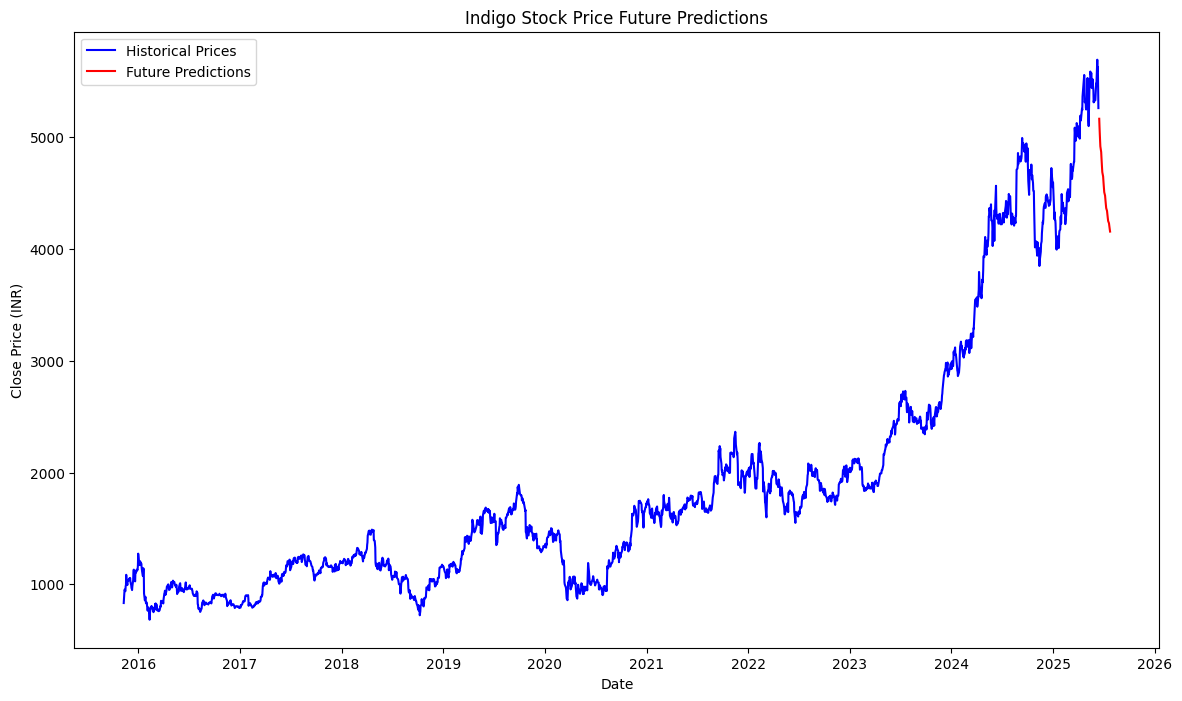

In [48]:
# Let's visualize the future predictions
future_dates = pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=1), periods=30, freq='B')
future_df = pd.DataFrame(data={'date': future_dates, 'Predictions': scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()})
plt.figure(figsize=(14, 8))
plt.plot(data['date'], data['close'], label='Historical Prices', color='blue')
plt.plot(future_df['date'], future_df['Predictions'], label='Future Predictions', color='red')
plt.title('Indigo Stock Price Future Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')
plt.legend()
plt.show()
